**Determination of the dominant physical processes in downward-propagating flame spread over a solid fuel using machine learning**

In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import sklearn as sk
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import SparsePCA
from scipy.io import loadmat
import h5py
from scipy import sparse, linalg
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import os
import matplotlib as mpl
mpl.rcParams['font.serif'] = ['Times new roman']
mpl.rc('xtick', labelsize=17)
mpl.rc('ytick', labelsize=17) 
mpl.rcParams['font.family']='Times new roman'
mpl.rcParams['axes.labelsize']=17
mpl.rcParams['axes.labelweight']='bold'
plt.rcParams['savefig.dpi'] = 500
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import ListedColormap
import seaborn as sns
sns_list = sns.color_palette('deep').as_hex()
sns_list.insert(0, '#ffffff')  # Insert white at zero position
sns_cmap = ListedColormap(sns_list)
cm = sns_cmap
mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
            '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
            '#bcbd22', '#17becf']

In [2]:
# parameters
from para import *
# load data
datadir = 'data'
# time
time = 45
timestep = np.round(time/(dt))
i = int(int(timestep/plotintv)*plotintv)
# velocity field
U = np.load((datadir+'\\Ux'+str(i)+'.npy'))
V = np.load((datadir+'\\Uy'+str(i)+'.npy'))
# temperature field
T = np.load((datadir+'\\T'+str(i)+'.npy'))
# density
rho = np.load((datadir+'\\rho'+str(i)+'.npy'))
# source w_g*Q_g/(rho*Cpg))
S_T = np.load((datadir+'\\S_T'+str(i)+'.npy'))
# mass fraction of fuel gas and oxygen
Fu=np.load((datadir+'\\Fu'+str(i)+'.npy'))
Ox=np.load((datadir+'\\Ox'+str(i)+'.npy'))
P=np.load((datadir+'\\P'+str(i)+'.npy'))

In [3]:
# obtain flame front location
Rho=np.load((datadir+'\\Rho_s'+str(i)+'.npy'))
# solid pyrolysis reaction
w_s=np.zeros([ny,nx])
w_s[Solid_matrix]= Rho[Solid_matrix] * Ac*np.exp(-Ec/(R*T[Solid_matrix]))
# fuel generation along surface of solid fuel
FuelGen=1.0*dy*np.sum(w_s,0)
# flame front location
if len(np.where(FuelGen>0.02)[0]):
        indx_f=np.where(FuelGen>0.02)[0][0]
        xf0=x[1,indx_f]
# Move the origin of the coordinate system to the flame front position
x = x - xf0
y = y - y[indxG_S,0]
# gas zone
X_g = x[indxG_S:,:]
Y_g = y[indxG_S:,:]
U_g = U[indxG_S:,:]
V_g = V[indxG_S:,:]
rho_g = rho[indxG_S:,:]
T_g = T[indxG_S:,:]
P_g = P[indxG_S:,:]
# solid zone
X_s = x[0:indxG_S,:]
Y_s = y[0:indxG_S,:]
T_s = T[0:indxG_S:,:]

## Temperature equation (gas phase)

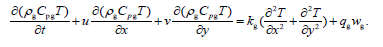

Text(0.5, 1.0, 'Temperature of solid phase (m/s)')

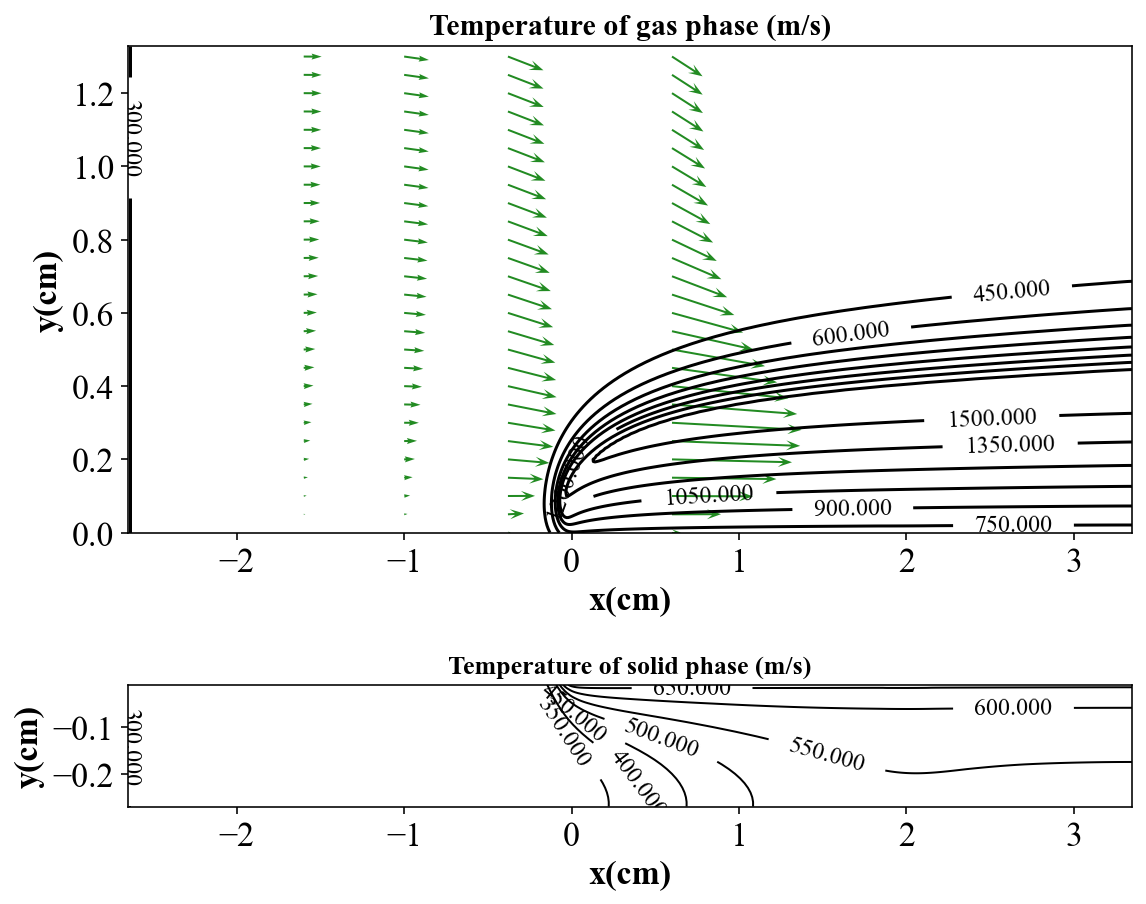

In [45]:
### temperature field
%matplotlib inline
from matplotlib import gridspec
fig = plt.figure(figsize=(9,7))
spec = gridspec.GridSpec(ncols=1, nrows=2,wspace=0.5,hspace=0.5, height_ratios=[4, 1])
ax0 = fig.add_subplot(spec[0])
cs=ax0.contour(X_g*100,Y_g*100,T_g,8,colors  ='k',linestyles='solid')
plt.ylabel('y(cm)')
plt.xlabel('x(cm)')
plt.clabel(cs, inline=1, fontsize=12)
plt.title('Temperature of gas phase (m/s)',fontdict={"fontsize":15,"fontweight":"bold","fontname":"Times new roman"})

# x-location of quiver 
indx_q0 = indx_f+60
indx_q1 = indx_f-38
indx_q2 = indx_f-100
indx_q3 = indx_f-160
# streamline in gas zone
cs_U=ax0.quiver(X_g[0::5,indx_q0]*100,Y_g[0::5,indx_q0]*100,U_g[0::5,indx_q0],V_g[0::5,indx_q0],
                width=0.002,color='forestgreen',linestyle='-.',minlength=0.4,scale=1.3,headwidth=5,headlength=7)

cs_U=ax0.quiver(X_g[0::5,indx_q1]*100,Y_g[0::5,indx_q1]*100,U_g[0::5,indx_q1],V_g[0::5,indx_q1],
                width=0.002,color='forestgreen',linestyle='-.',minlength=0.4,scale=0.7,headwidth=5,headlength=7)

cs_U=ax0.quiver(X_g[0::5,indx_q2]*100,Y_g[0::5,indx_q2]*100,U_g[0::5,indx_q2],V_g[0::5,indx_q2],
                width=0.002,color='forestgreen',linestyle='-.',minlength=0.01,scale=0.7) #headwidth=5,headlength=7

cs_U=ax0.quiver(X_g[0::5,indx_q3]*100,Y_g[0::5,indx_q3]*100,U_g[0::5,indx_q3],V_g[0::5,indx_q3],
                width=0.002,color='forestgreen',linestyle='-.',minlength=0.01,scale=0.7) #headwidth=5,headlength=7

# plot flame stand-off distance curve
# xdata = np.linspace(-0.0009,0.03,50000)
# ydata = 0.0109*(xdata+0.0009)**(0.2678) # x offset 0.0009 to correct the transition errors
# ax0.plot(xdata*100,ydata*100,linestyle='--',linewidth=2,color='r')

ax1 = fig.add_subplot(spec[1])
cs=ax1.contour(X_s*100,Y_s*100,T_s,8,colors  ='k',linestyles='solid',linewidths=1)
plt.ylabel('y(cm)')
plt.xlabel('x(cm)')
plt.clabel(cs, inline=1, fontsize=12)
plt.title('Temperature of solid phase (m/s)',fontdict={"fontsize":13,"fontweight":"bold","fontname":"Times new roman"})



### Equation space

In [46]:
rhoCpg_UTx = rhog*Cpg*(U[1:-1,1:-1] + Uf) * (T[1:-1,2:]-T[1:-1,0:-2])/(2*dx) # U minus (-Uf) means moving the origin to the front of the flame
rhoCpg_VTy = rhog*Cpg*V[1:-1,1:-1] * (T[2:,1:-1]-T[0:-2,1:-1])/(2*dy)
aTxx = kg*(T[1:-1,2:]- 2*T[1:-1,1:-1] + T[1:-1,0:-2])/(dx**2)
aTyy = kg*(T[2:,1:-1]- 2*T[1:-1,1:-1] + T[0:-2,1:-1])/(dy**2)
lap_T = aTxx + aTyy # laplacian term
S_T_sg = rhog*Cpg*S_T[1:-1,1:-1] # source in gas

X = x[1:-1,1:-1]
Y = y[1:-1,1:-1]

# extract the results in gas phase
rhoCpg_UTx = rhoCpg_UTx[indxG_S-1:,:]
rhoCpg_VTy = rhoCpg_VTy[indxG_S-1:,:]
lap_T = lap_T[indxG_S-1:,:]
S_T_sg = S_T_sg[indxG_S-1:,:]
X = X[indxG_S-1:,:]
Y = Y[indxG_S-1:,:]

<ipython-input-47-2bc3a829290b>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X*100, Y*100, rhoCpg_UTx, vmin=-clim, vmax=clim, cmap='RdBu')
<ipython-input-47-2bc3a829290b>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X*100, Y*100, rhoCpg_VTy, vmin=-clim, vmax=clim, cmap='RdBu')
<ipython-input-47-2bc3a829290b>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3

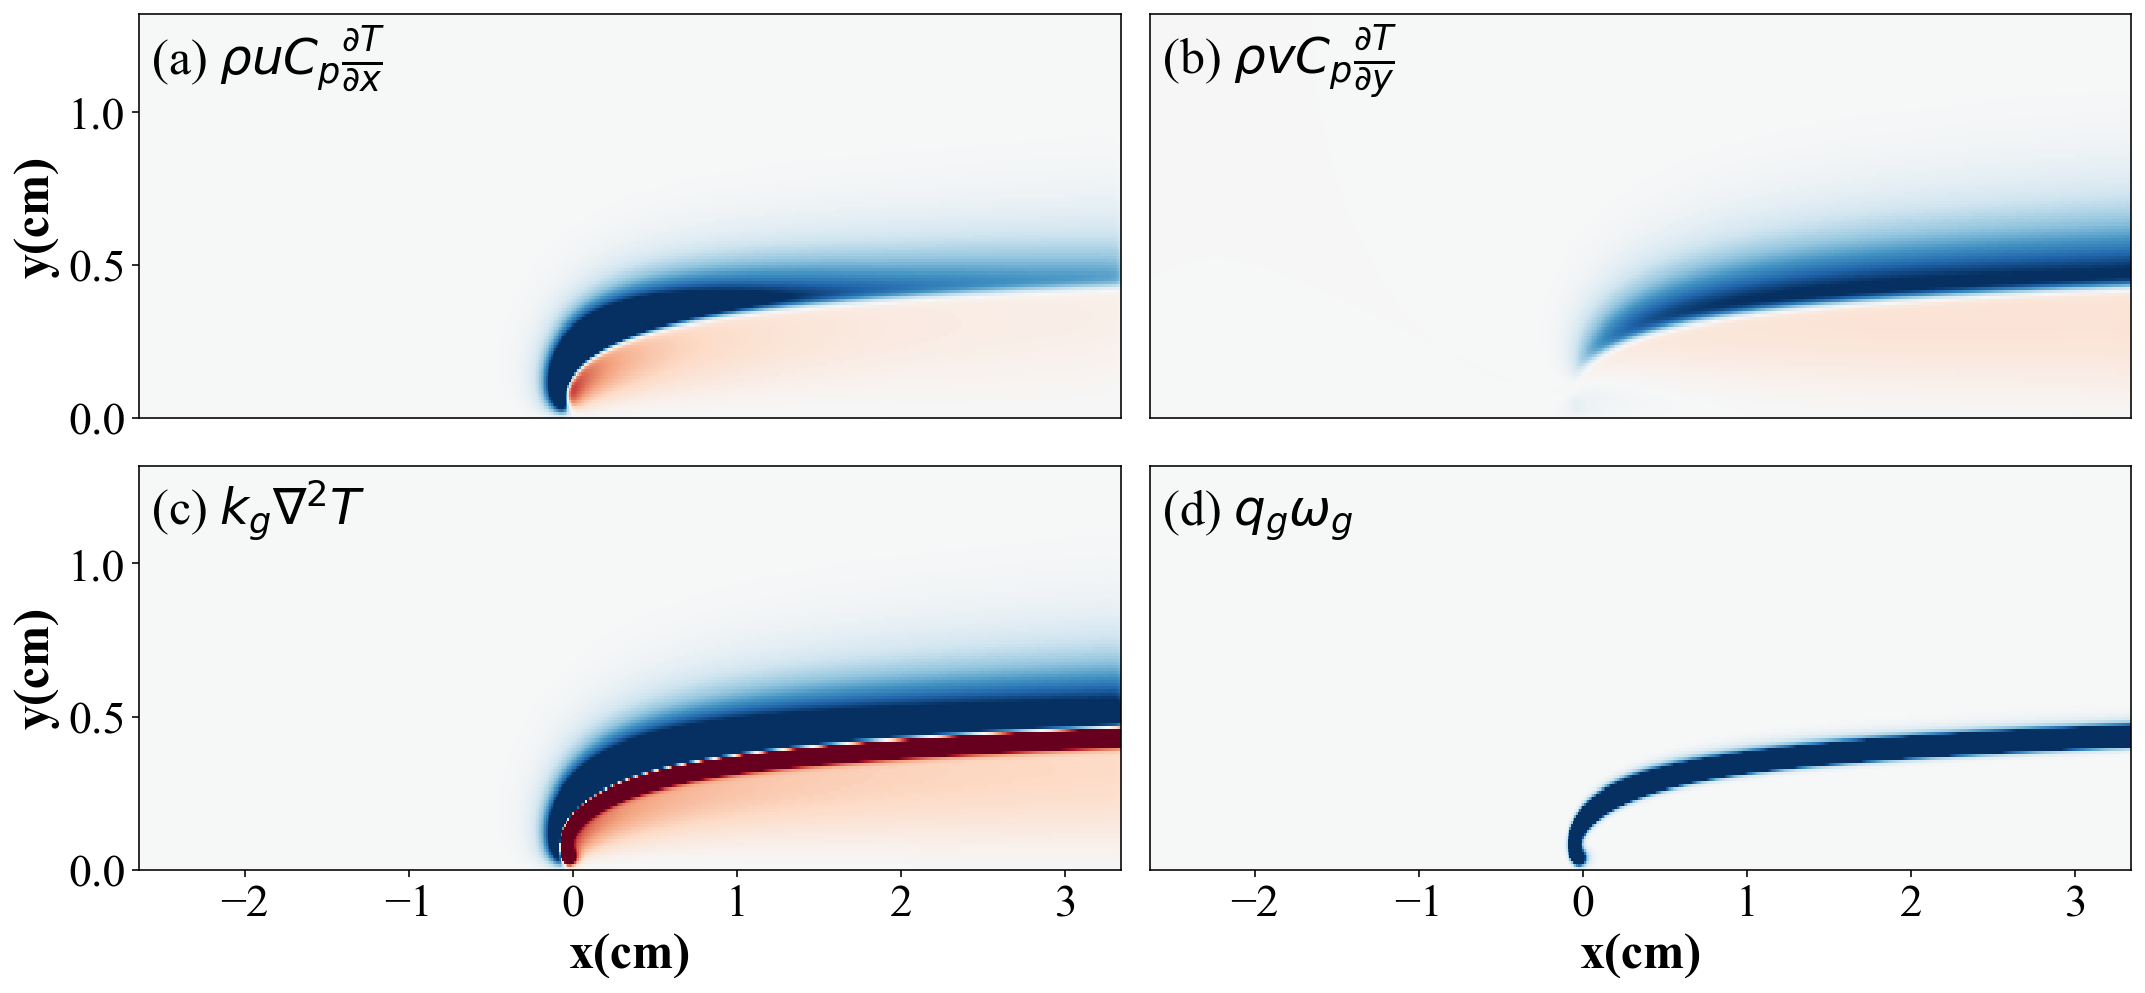

In [47]:
# draw the 2D distribution of the four terms in gas heat transfer equation
labels = [r'$ \rho u C_p \frac{\partial T}{\partial x}$', 
          r'$  \rho v C_p \frac{\partial T}{\partial y}$',
          r'$ k_g \nabla^2 T $', 
          r'$ q_g ω_g $']
clim =1.4e7
fontsize=25
%matplotlib inline
fig=plt.figure(figsize=(15,7))

plt.subplot(221)
im = plt.pcolor(X*100, Y*100, rhoCpg_UTx, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
# plt.gca().set_yticks([])
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.title(' (a) '+labels[0], fontsize=fontsize,loc='left',y=1.0, pad=-30)
plt.ylabel('y(cm)',fontsize=fontsize)

plt.subplot(222)
plt.pcolor(X*100, Y*100, rhoCpg_VTy, vmin=-clim, vmax=clim, cmap='RdBu')
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.title(' (b) '+labels[1], fontsize=fontsize,loc='left',y=1.0, pad=-30)

plt.subplot(223)
plt.pcolor(X*100, Y*100, lap_T, vmin=-clim, vmax=clim, cmap='RdBu')
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.title(' (c) '+labels[2], fontsize=fontsize,loc='left',y=1.0, pad=-30)
plt.ylabel('y(cm)',fontsize=fontsize)
plt.xlabel('x(cm)',fontsize=fontsize)

plt.subplot(224)
plt.pcolor(X*100, Y*100, S_T_sg, vmin=-clim, vmax=clim, cmap='RdBu')
# plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.xticks(fontsize=fontsize-2)
plt.yticks(fontsize=fontsize-2)
plt.title(' (d) '+labels[3],fontsize=fontsize,loc='left',y=1.0, pad=-30)
plt.xlabel('x(cm)',fontsize=fontsize)

fig.set_tight_layout(True)
# cb_ax = fig.add_axes([0.8, 0.1, 0.02, 0.8]) 
# cbar = fig.colorbar(im, cax=cb_ax)     #shared colorbar
# cb_ax.tick_params(axis='y', labelsize=fontsize)

### Gaussian mixture model

In [78]:
# flatten the data
features = np.hstack([rhoCpg_UTx.reshape((-1,1)), rhoCpg_VTy.reshape((-1,1)), lap_T.reshape((-1,1)), S_T_sg.reshape((-1,1))])/(Cpg*rhog)
nfeatures = features.shape[1] # feature number
# Fit Gaussian mixture model
nc = 6 # Number of clusters 5,6
seed = 3696291
model = GaussianMixture(n_components=nc, random_state=seed,max_iter =1000)
model.fit(features)
# "Predict" clusters in entire domain
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, rhoCpg_UTx.shape)

### SPCA reduction

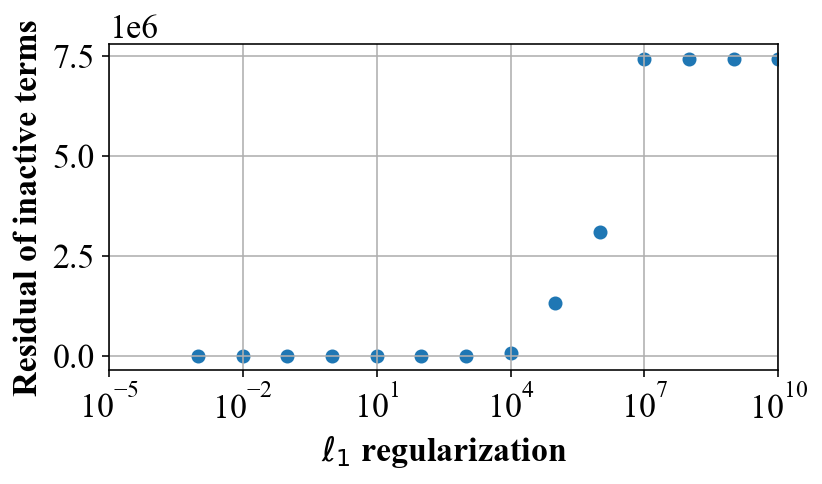

In [79]:
#identify directions of nonzero variance using Sparse PCA 
#   First step: model selection for L1 regularization
alphas = [ 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5,1e6, 1e7, 1e8,1e9,1e10]
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k])#, normalize_components=True)
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel(r'$\ell_1$ regularization')
plt.ylabel('Residual of inactive terms')
plt.gca().set_xscale('log')
plt.xlim([1e-5, 1e10])
plt.grid()
plt.show()

In [80]:
# Use sparse principal component analysis to analyze each cluster to get the principal component corresponding to each cluster
alpha_opt =100000
spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')
# print(spca_model)

GMM Cluster 0:
None
GMM Cluster 1:
['$ \\rho u C_p \\frac{\\partial T}{\\partial x}$', '$  \\rho v C_p \\frac{\\partial T}{\\partial y}$', '$ k_g \\nabla^2 T $']
GMM Cluster 2:
None
GMM Cluster 3:
['$  \\rho v C_p \\frac{\\partial T}{\\partial y}$', '$ k_g \\nabla^2 T $']
GMM Cluster 4:
['$ k_g \\nabla^2 T $', '$ q_g ω_g $']
GMM Cluster 5:
['$ \\rho u C_p \\frac{\\partial T}{\\partial x}$', '$  \\rho v C_p \\frac{\\partial T}{\\partial y}$', '$ k_g \\nabla^2 T $']


### Final dominant balance models

In [81]:
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)# To merge clusters with the same principal components
nmodels = balance_models.shape[0]
print(balance_models) # [balance_clurse, feature]
print(model_index)

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: 
        print('No dynamics')
# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])  # Divide the original class into classes in the principal component to determine the principal component feature of each region
balancemap = np.reshape(balance_idx, rhoCpg_UTx.shape)

[[0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 1. 1. 0.]
 [1. 1. 1. 0.]]
[0 3 0 2 1 3]
SPCA Cluster 0:
No dynamics
SPCA Cluster 1:
['$ k_g \\nabla^2 T $', '$ q_g ω_g $']
SPCA Cluster 2:
['$  \\rho v C_p \\frac{\\partial T}{\\partial y}$', '$ k_g \\nabla^2 T $']
SPCA Cluster 3:
['$ \\rho u C_p \\frac{\\partial T}{\\partial x}$', '$  \\rho v C_p \\frac{\\partial T}{\\partial y}$', '$ k_g \\nabla^2 T $']


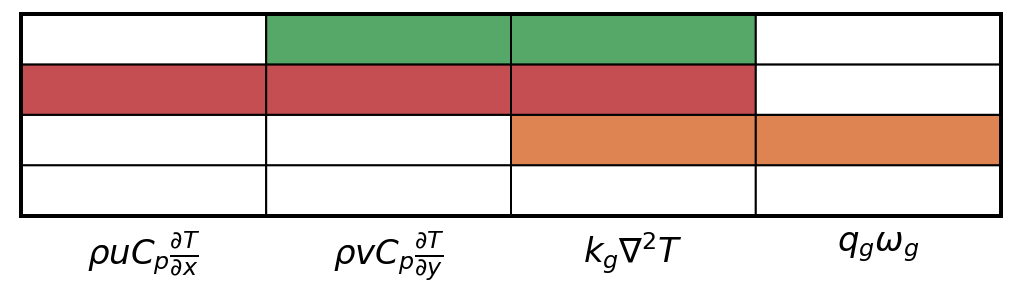

In [85]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap == 0
gridmap = (gridmap.T*np.arange(nmodels)).T+1  # [feature,nc]*range(0,nc)->[feature,nc]-T->[nc,feature] (1~nc): Scale map so that active terms can be color-coded
gridmap[gridmask] = 0 # unactive term remains 0
# print("gridmap:\n",gridmap)
grid_labels=labels
%matplotlib inline
plt.figure(figsize=(8, 2))
plt.axes((0.1, 0.24,0.85, 0.7), facecolor='w')
gridmap = gridmap[[0,1,3,2],:] # Exchange of two rows. this operation didn't change the final result
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, gridmap.shape[1]+0.5))
plt.gca().set_xticklabels(grid_labels, fontsize=17)
plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
plt.gca().set_yticklabels(range(gridmap.shape[0]), fontsize=17)
plt.gca().set_yticklabels([])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)

plt.gca().tick_params(axis='both', width=0)
plt.show()

<ipython-input-86-d664cbc51dfd>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X*100, Y*100, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')


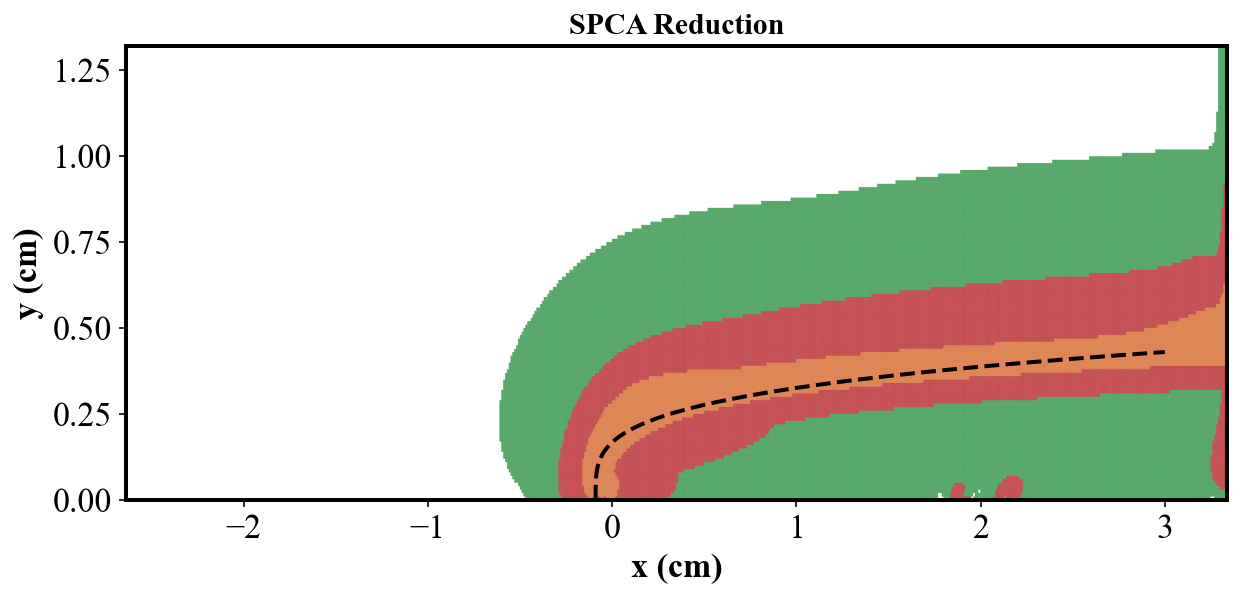

In [86]:
id_noBalance_cluser = np.where(gridmap.sum(axis=1)==0)[0]# remain zoros If there is no principal component in the original gridmap
balancemap[balancemap==id_noBalance_cluser]=-1

%matplotlib inline
fig = plt.figure(figsize=(9, 4.5))
ax=fig.add_axes([0.1,0.15,0.85,0.7])
ax.pcolor(X*100, Y*100, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')

plt.ylabel('y (cm)')
plt.xlabel('x (cm)')

plt.title('SPCA Reduction',fontdict={"fontsize":15,"fontweight":"bold","fontname":"Times new roman"})

# plot flame stand-off distance curve
xdata = np.linspace(-0.0009,0.03,50000)
ydata = 0.0109*(xdata+0.0009)**(0.2678) # x offset 0.0009 to correct the transition errors
plt.plot(xdata*100,ydata*100,linestyle='--',linewidth=2,color='k')

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)
plt.show()

## Temerature equation（solid phase）

### Equation space

In [13]:
rhoCpg_UTx = rho[1:-1,1:-1]*Cps*(U[1:-1,1:-1] + Uf) * (T[1:-1,2:]-T[1:-1,0:-2])/(2*dx) # # U minus (-Uf) means moving the origin to the front of the flame
aTxx = rho[1:-1,1:-1]*Cps*a[1:-1,1:-1]*(T[1:-1,2:]- 2*T[1:-1,1:-1] + T[1:-1,0:-2])/(dx**2)
aTyy = rho[1:-1,1:-1]*Cps*a[1:-1,1:-1]*(T[2:,1:-1]- 2*T[1:-1,1:-1] + T[0:-2,1:-1])/(dy**2)
lap_T = aTxx + aTyy # laplacian 
S_T_sg = rho[1:-1,1:-1]*Cps*S_T[1:-1,1:-1] # 

X = x[1:-1,1:-1]
Y = y[1:-1,1:-1]

# capture data in gas phase
rhoCpg_UTx = rhoCpg_UTx[:indxG_S,:]
lap_T = lap_T[:indxG_S,:]
S_T_sg = S_T_sg[:indxG_S,:]
X = X[:indxG_S,:]
Y = Y[:indxG_S,:]

### Gaussian mixture model

In [14]:
labels = [r'$\rho_s C_s V_f \frac{\partial T}{\partial x}$', 
          r'$ k_s \nabla^2 T $', 
          r'$q_c ω_c$']
features = np.hstack([rhoCpg_UTx.reshape((-1,1)), lap_T.reshape((-1,1)), S_T_sg.reshape((-1,1))])/(Cps*rho_s)
nfeatures = features.shape[1]
# Fit Gaussian mixture model
nc = 6 # Number of clusters
seed = 3696291  #  Keep a seed for debugging/plotting
model = GaussianMixture(n_components=nc, random_state=seed,max_iter =1000)

# PERMUTATION
model.fit(features)
# "Predict" clusters in entire domain
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, rhoCpg_UTx.shape)

### SPCA reduction

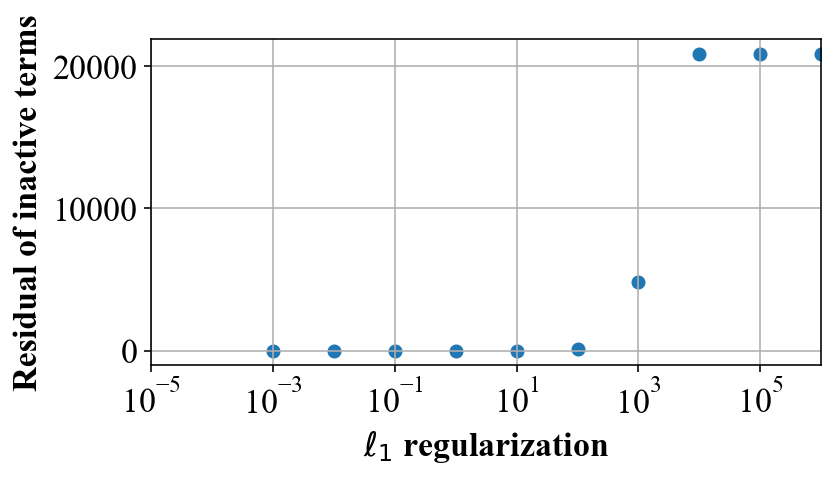

In [15]:
# Sparse PCA to identify directions of nonzero variance
#   First step: model selection for L1 regularization
alphas = [ 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5,1e6]
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k])#, normalize_components=True)
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
    
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel(r'$\ell_1$ regularization')
plt.ylabel('Residual of inactive terms')
plt.gca().set_xscale('log')
plt.xlim([1e-5, 1e6])
plt.grid()
plt.show()

In [16]:
# Sparse principal component analysis is used to analyze each cluster to obtain the corresponding principal components of each cluster
alpha_opt =100
spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt)# normalize_components=True)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')

# print(spca_model)

GMM Cluster 0:
None
GMM Cluster 1:
['$\\rho_s C_s V_f \\frac{\\partial T}{\\partial x}$', '$ k_s \\nabla^2 T $']
GMM Cluster 2:
['$\\rho_s C_s V_f \\frac{\\partial T}{\\partial x}$', '$ k_s \\nabla^2 T $', '$q_c ω_c$']
GMM Cluster 3:
['$\\rho_s C_s V_f \\frac{\\partial T}{\\partial x}$', '$ k_s \\nabla^2 T $', '$q_c ω_c$']
GMM Cluster 4:
['$ k_s \\nabla^2 T $', '$q_c ω_c$']
GMM Cluster 5:
['$\\rho_s C_s V_f \\frac{\\partial T}{\\partial x}$', '$ k_s \\nabla^2 T $', '$q_c ω_c$']


In [17]:
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)# # To merge clusters with the same principal components
nmodels = balance_models.shape[0]
print(balance_models) # [balance_clurse, feature]
print(model_index)

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: 
        
        print('No dynamics')

# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])  # Divide the original class into classes in the principal component to determine the principal component feature of each region
balancemap = np.reshape(balance_idx, rhoCpg_UTx.shape)

[[0. 0. 0.]
 [0. 1. 1.]
 [1. 1. 0.]
 [1. 1. 1.]]
[0 2 3 3 1 3]
SPCA Cluster 0:
No dynamics
SPCA Cluster 1:
['$ k_s \\nabla^2 T $', '$q_c ω_c$']
SPCA Cluster 2:
['$\\rho_s C_s V_f \\frac{\\partial T}{\\partial x}$', '$ k_s \\nabla^2 T $']
SPCA Cluster 3:
['$\\rho_s C_s V_f \\frac{\\partial T}{\\partial x}$', '$ k_s \\nabla^2 T $', '$q_c ω_c$']


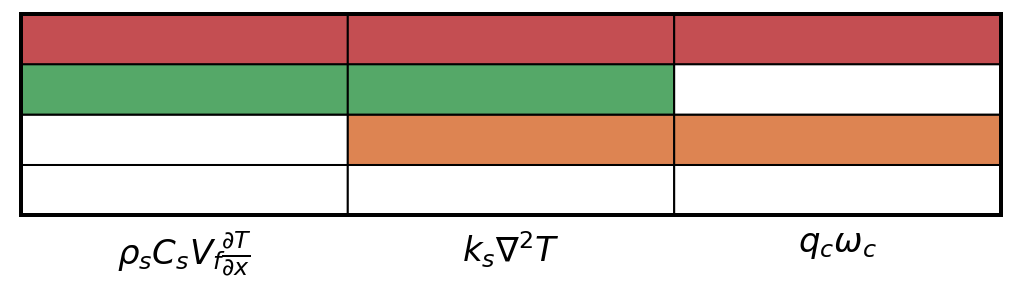

In [18]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap==0
gridmap = (gridmap.T*np.arange(nmodels)).T+1  # [feature,nc]*range(0,nc)->[feature,nc]-T->[nc,feature] (1~nc): Scale map so that active terms can be color-coded
gridmap[gridmask] = 0 # unactive term remains 0
grid_labels=labels

%matplotlib inline
plt.figure(figsize=(8, 2))
plt.axes((0.1, 0.24,0.85, 0.7), facecolor='w')
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, gridmap.shape[1]+0.5))
plt.gca().set_xticklabels(grid_labels, fontsize=17)

plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
# plt.gca().set_yticklabels(range(gridmap.shape[0]), fontsize=17)
plt.gca().set_yticklabels([])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)

plt.gca().tick_params(axis='both', width=0)
plt.show()

<ipython-input-19-2334b2dd81a9>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X*100, Y*100, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')
<ipython-input-19-2334b2dd81a9>:15: RuntimeWarning: invalid value encountered in sqrt
  ydata = 0.0108*(xdata-0.001)**(1/2) # x offset -0.001 to correct the transition errors


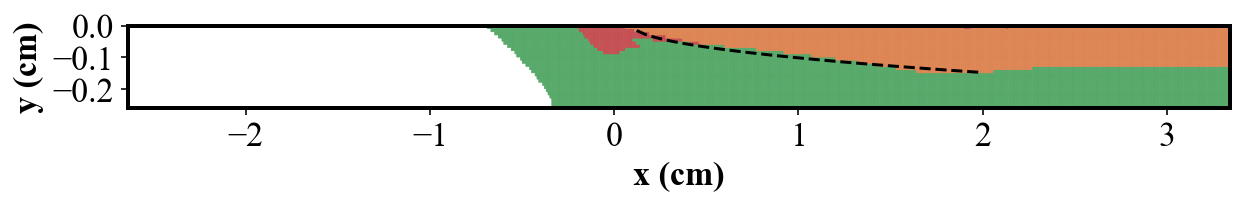

In [19]:
id_noBalance_cluser = np.where(gridmap.sum(axis=1)==0)[0]# remain zoros If there is no principal component in the original gridmap
balancemap[balancemap==id_noBalance_cluser]=-1
%matplotlib inline
fig = plt.figure(figsize=(9, 1.9))
ax=fig.add_axes([0.1,0.33,0.85,0.3])
ax.pcolor(X*100, Y*100, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')

plt.ylabel('y (cm)')
plt.xlabel('x (cm)')
plt.yticks(-np.array([0,0.1,0.2]))
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)
# plot curve 
xdata = np.linspace(2e-04,0.02,40)
ydata = 0.0108*(xdata-0.001)**(1/2) # x offset -0.001 to correct the transition errors
plt.plot(xdata*100,-ydata*100,linestyle='--',color='k')
plt.show()

## Flow equations

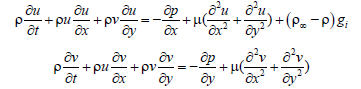

Text(0.5, 1.0, 'V (m/s)')

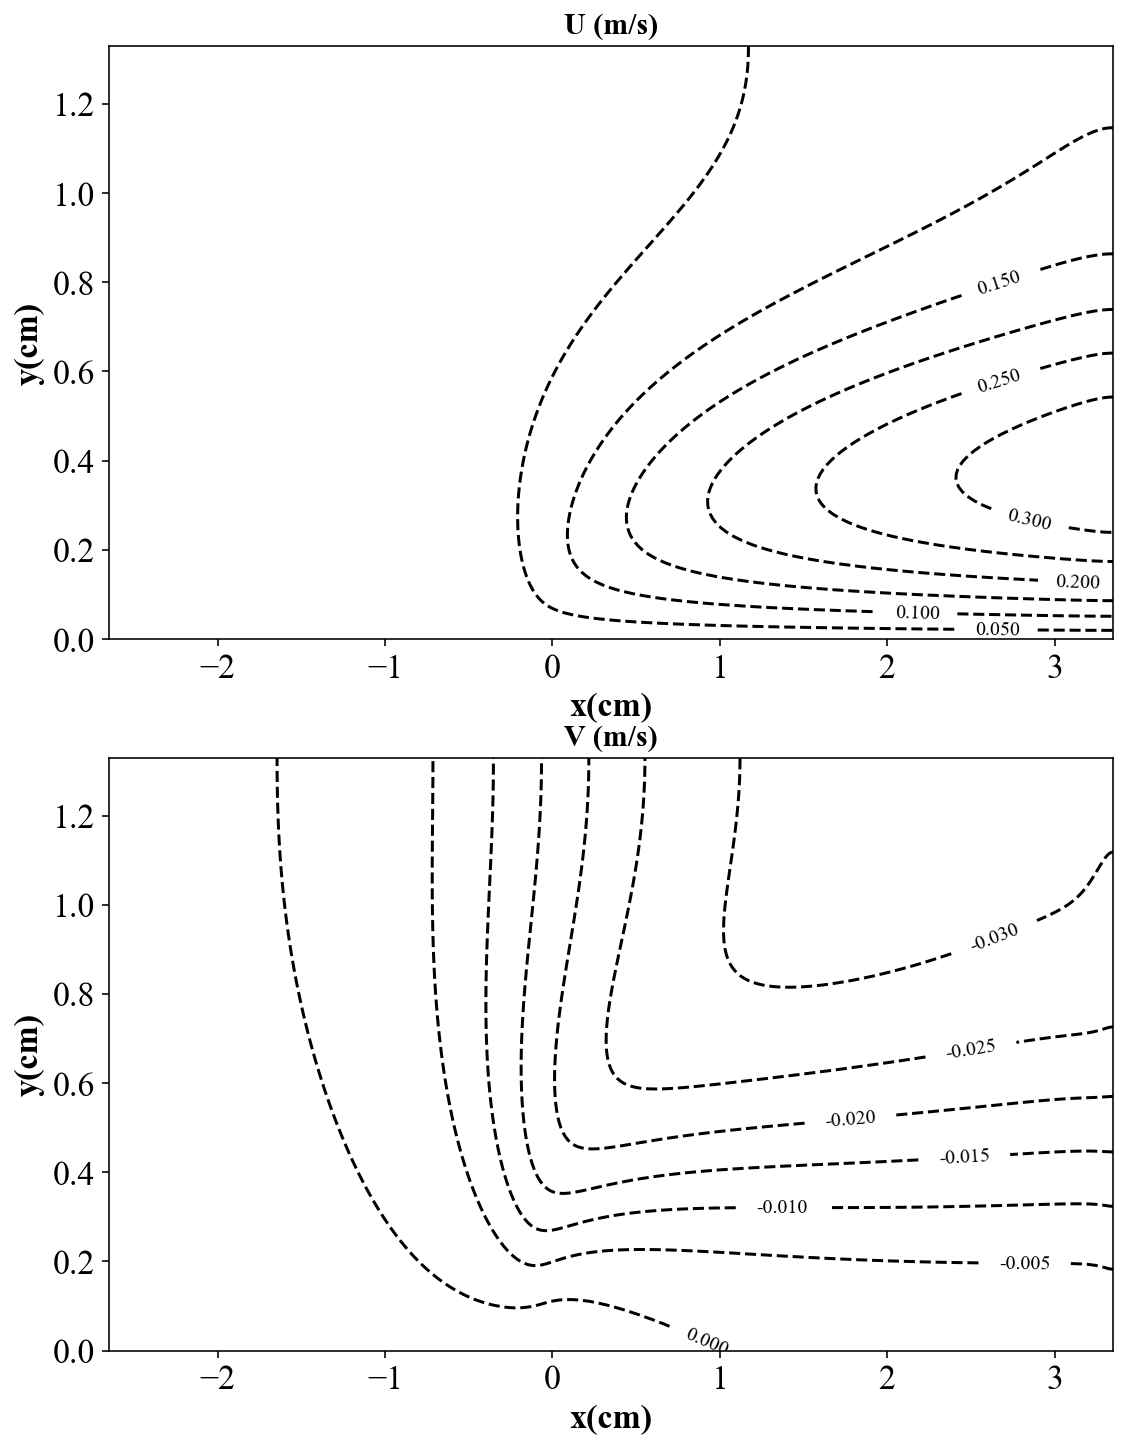

In [20]:
### velocity field
plt.rcParams['savefig.dpi'] = 500
%matplotlib inline
plt.figure(figsize=(9,12))
plt.subplot(211)
cs=plt.contour(X_g*100,Y_g*100,U_g,colors  ='k',linestyles='dashed')
plt.ylabel('y(cm)')
plt.xlabel('x(cm)')
plt.clabel(cs, inline=1, fontsize=10)
plt.title('U (m/s)',fontdict={"fontsize":15,"fontweight":"bold","fontname":"Times new roman"})

plt.subplot(212)
cs=plt.contour(X_g*100,Y_g*100,V_g,colors  ='k',linestyles='dashed')
plt.ylabel('y(cm)')
plt.xlabel('x(cm)')
plt.clabel(cs, inline=1, fontsize=10)
plt.title('V (m/s)',fontdict={"fontsize":15,"fontweight":"bold","fontname":"Times new roman"})


### Equation space

In [21]:
rhoUUx = rho_g[1:-1,1:-1]*(U_g[1:-1,1:-1] + Uf) * (U_g[1:-1,2:]-U_g[1:-1,0:-2])/(2*dx) # U minus (-Uf) means moving the origin to the front of the flame
rhoVUy = rho_g[1:-1,1:-1]*V_g[1:-1,1:-1] * (U_g[2:,1:-1]-U_g[0:-2,1:-1])/(2*dy)
nuUxx = rho_g[1:-1,1:-1]*nu*(U_g[1:-1,2:]- 2*U_g[1:-1,1:-1] +U_g[1:-1,0:-2])/(dx**2)
nuUyy = rho_g[1:-1,1:-1]*nu*(U_g[2:,1:-1]- 2*U_g[1:-1,1:-1] +U_g[0:-2,1:-1])/(dy**2)
lap_U = nuUxx+nuUyy # laplacian 
bouyancy = (rho_a - rho_g[1:-1,1:-1])*g
px_rho = (bouyancy + lap_U - rhoUUx - rhoVUy) 

X = X_g[1:-1,1:-1]
Y = Y_g[1:-1,1:-1]

### Gaussian mixture model

In [22]:

labels = [r'$\rho u \frac{\partial u}{\partial x}$', r'$\rho v \frac{\partial u}{\partial y} $', r'$ \frac{\partial p}{\partial x}$',
          r'$\mu \nabla^2 U$', r'$ (\rho_{∞}-\rho)g $']
# flatten the data
# Advection, pressure, viscous, Reynolds stresses
features = np.hstack([rhoUUx.reshape((-1,1)), rhoVUy.reshape((-1,1)), px_rho.reshape((-1,1)), lap_U.reshape((-1,1)),bouyancy.reshape((-1,1))])/rho_g[1:-1,1:-1].reshape((-1,1))
nfeatures = features.shape[1]
# Fit Gaussian mixture model
nc =5# Number of clusters 5
seed = 3696299931  #  Keep a seed for debugging/plotting
model = GaussianMixture(n_components=nc, random_state=seed,max_iter = 1000)
# PERMUTATION
model.fit(features)
# "Predict" clusters in entire domain
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, rhoUUx.shape)

### SPCA reduction

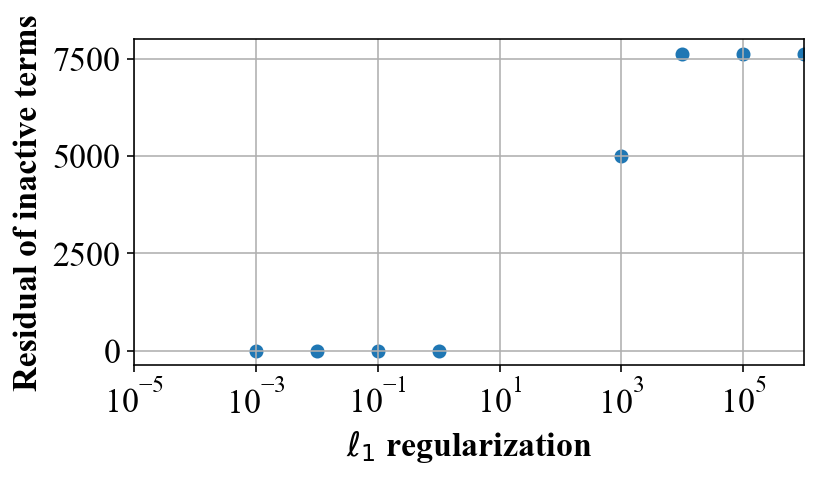

In [23]:
# Sparse PCA to identify directions of nonzero variance
#  First step: model selection for L1 regularization
alphas = [ 1e-3, 1e-2, 0.1, 1, 1e3, 1e4, 1e5,1e6]
err = np.zeros([len(alphas)])  
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k])#, normalize_components=True)
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
    
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel(r'$\ell_1$ regularization')
plt.ylabel('Residual of inactive terms')
plt.gca().set_xscale('log')
plt.xlim([1e-5, 1e6])
plt.grid()
plt.show()

In [24]:
# Sparse principal component analysis is used to analyze each cluster to obtain the corresponding principal components of each cluster
alpha_opt =4
spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt)# normalize_components=True)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')

# print(spca_model)

GMM Cluster 0:
None
GMM Cluster 1:
['$\\rho u \\frac{\\partial u}{\\partial x}$', '$\\rho v \\frac{\\partial u}{\\partial y} $', '$ \\frac{\\partial p}{\\partial x}$', '$\\mu \\nabla^2 U$', '$ (\\rho_{∞}-\\rho)g $']
GMM Cluster 2:
['$\\rho u \\frac{\\partial u}{\\partial x}$', '$\\rho v \\frac{\\partial u}{\\partial y} $', '$ \\frac{\\partial p}{\\partial x}$', '$ (\\rho_{∞}-\\rho)g $']
GMM Cluster 3:
['$\\rho u \\frac{\\partial u}{\\partial x}$', '$ \\frac{\\partial p}{\\partial x}$', '$\\mu \\nabla^2 U$', '$ (\\rho_{∞}-\\rho)g $']
GMM Cluster 4:
['$\\rho u \\frac{\\partial u}{\\partial x}$', '$\\rho v \\frac{\\partial u}{\\partial y} $', '$ \\frac{\\partial p}{\\partial x}$']


### Final dominant balance models

In [25]:
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)# To merge clusters with the same principal components
nmodels = balance_models.shape[0]
print(balance_models) # [balance_clurse, feature]
print(model_index)

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: 
        print('No dynamics')

# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx]) # Divide the original class into classes in the principal component to determine the principal component feature of each region
balancemap = np.reshape(balance_idx, rhoUUx.shape)

[[0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1.]
 [1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1.]]
[0 4 3 1 2]
SPCA Cluster 0:
No dynamics
SPCA Cluster 1:
['$\\rho u \\frac{\\partial u}{\\partial x}$', '$ \\frac{\\partial p}{\\partial x}$', '$\\mu \\nabla^2 U$', '$ (\\rho_{∞}-\\rho)g $']
SPCA Cluster 2:
['$\\rho u \\frac{\\partial u}{\\partial x}$', '$\\rho v \\frac{\\partial u}{\\partial y} $', '$ \\frac{\\partial p}{\\partial x}$']
SPCA Cluster 3:
['$\\rho u \\frac{\\partial u}{\\partial x}$', '$\\rho v \\frac{\\partial u}{\\partial y} $', '$ \\frac{\\partial p}{\\partial x}$', '$ (\\rho_{∞}-\\rho)g $']
SPCA Cluster 4:
['$\\rho u \\frac{\\partial u}{\\partial x}$', '$\\rho v \\frac{\\partial u}{\\partial y} $', '$ \\frac{\\partial p}{\\partial x}$', '$\\mu \\nabla^2 U$', '$ (\\rho_{∞}-\\rho)g $']


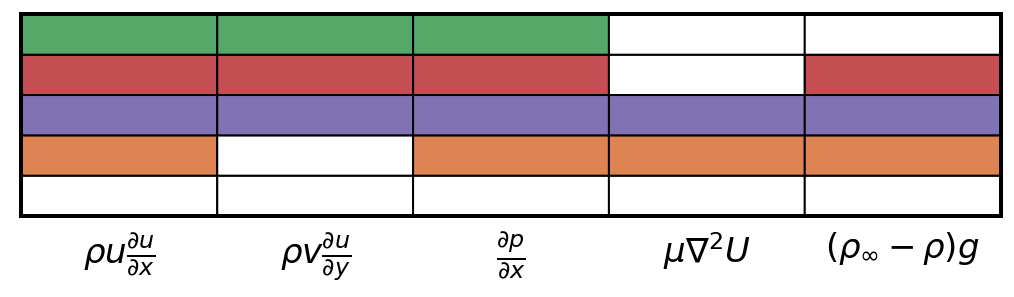

In [26]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap==0
gridmap = (gridmap.T*np.arange(nmodels)).T+1  # [feature,nc]*range(0,nc)->[feature,nc]-T->[nc,feature] (1~nc): Scale map so that active terms can be color-coded
gridmap[gridmask] = 0 # unactive term remains 0
# print("gridmap:\n",gridmap)
grid_labels=labels

%matplotlib inline
plt.figure(figsize=(8, 2))
plt.axes((0.1, 0.24,0.85, 0.7), facecolor='w')
gridmap = gridmap[[0,1,4,3,2],:] # Exchange of two rows. this operation didn't change the final result
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, gridmap.shape[1]+0.5))
plt.gca().set_xticklabels(grid_labels, fontsize=17)
plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
plt.gca().set_yticklabels([])
# plt.gca().set_yticklabels(range(gridmap.shape[0]), fontsize=17)

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)
plt.gca().tick_params(axis='both', width=0)
plt.show()

<ipython-input-27-512c6bbfb6c2>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X*100, Y*100, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')


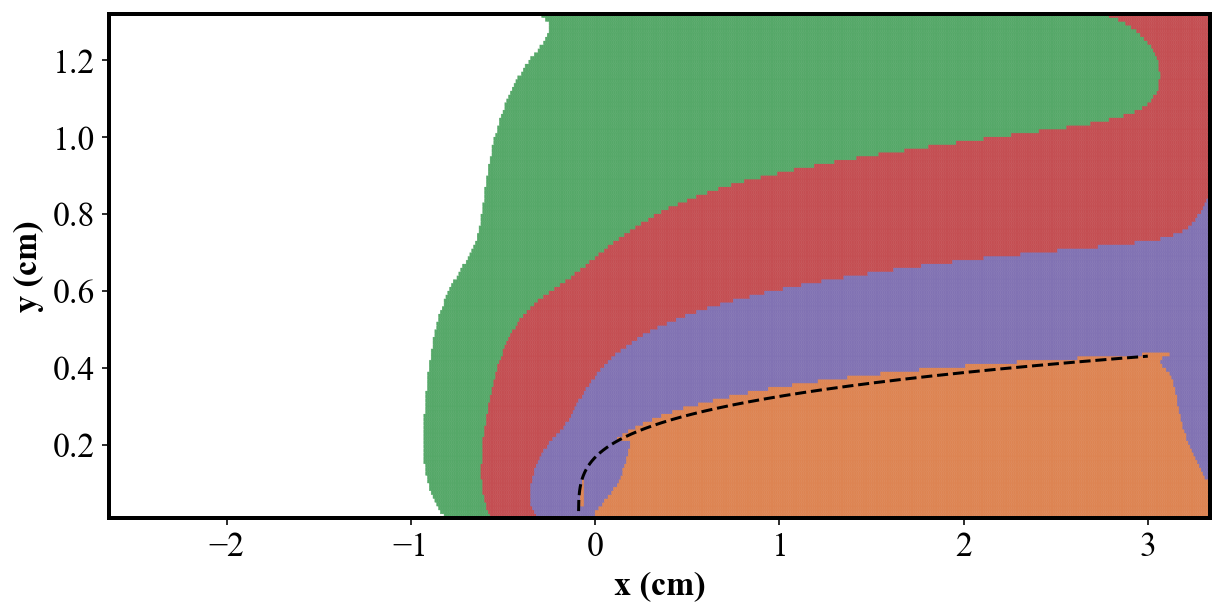

In [27]:
id_noBalance_cluser = np.where(gridmap.sum(axis=1)==0)[0]# remain zoros If there is no principal component in the original gridmap
balancemap[balancemap==id_noBalance_cluser]=-1

%matplotlib inline

fig= plt.figure(figsize=(9, 5))
ax=fig.add_axes([0.1,0.2,0.85,0.7])
ax.pcolor(X*100, Y*100, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')
plt.ylabel('y (cm)')
plt.xlabel('x (cm)')
# plt.title('SPCA Reduction',fontdict={"fontsize":15,"fontweight":"bold","fontname":"Times new roman"})
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)

# plot flame stand-off distance curve
xdata = np.linspace(-0.000899,0.03,50000)
ydata = 0.0109*(xdata+0.0009)**(0.2678) # x offset 0.0009 to correct the transition errors
plt.plot(xdata*100,ydata*100,linestyle='--',color='k')

plt.show()

## Species equations

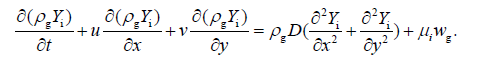

<ipython-input-28-4edb2b393806>:5: UserWarning: The following kwargs were not used by contour: 'label'
  cs_fu=plt.contour(X_g*100,Y_g*100,Fu[indxG_S:,:],8,colors  ='k',linestyles='solid',linewidths=1,label='Fuel gas')
<ipython-input-28-4edb2b393806>:11: UserWarning: The following kwargs were not used by contour: 'label'
  cs_ox=plt.contour(X_g*100,Y_g*100,Ox[indxG_S:,:],8,colors  ='b',linestyles='solid',linewidths=1,label='Oxygen')


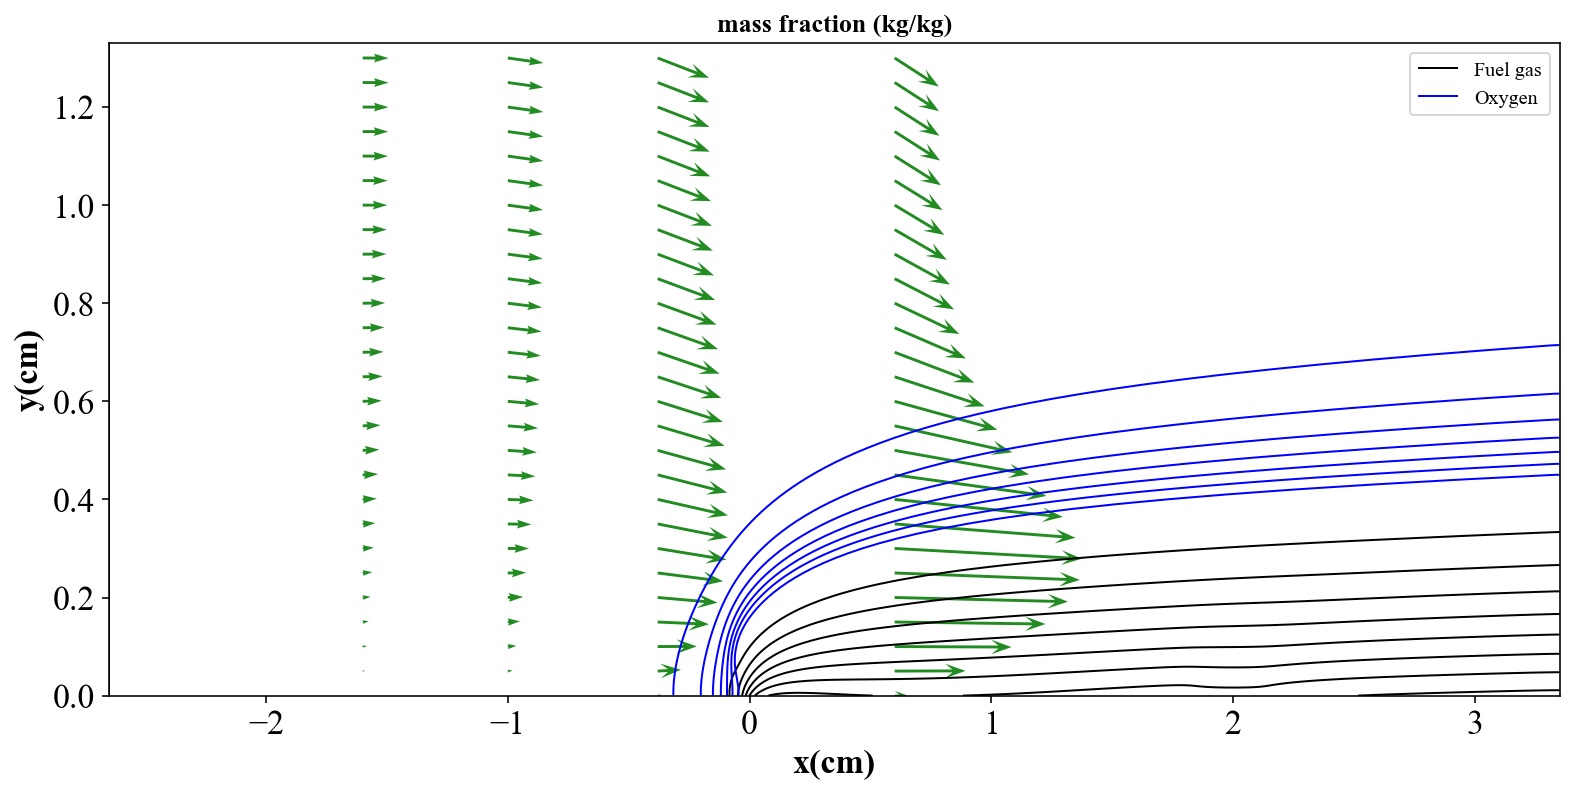

In [28]:
%matplotlib inline
from matplotlib import gridspec

fig = plt.figure(figsize=(13,6))
cs_fu=plt.contour(X_g*100,Y_g*100,Fu[indxG_S:,:],8,colors  ='k',linestyles='solid',linewidths=1,label='Fuel gas')
plt.ylabel('y(cm)')
plt.xlabel('x(cm)')
plt.clabel(cs, inline=1, fontsize=12)
plt.title('mass fraction (kg/kg)',fontdict={"fontsize":15,"fontweight":"bold","fontname":"Times new roman"})

cs_ox=plt.contour(X_g*100,Y_g*100,Ox[indxG_S:,:],8,colors  ='b',linestyles='solid',linewidths=1,label='Oxygen')
plt.ylabel('y(cm)')
plt.xlabel('x(cm)')
plt.clabel(cs, inline=1, fontsize=12)
plt.title('mass fraction (kg/kg)',fontdict={"fontsize":13,"fontweight":"bold","fontname":"Times new roman"})

# x location of quiver
indx_q0 = indx_f+60
indx_q1 = indx_f-38
indx_q2 = indx_f-100
indx_q3 = indx_f-160

# cs_U=plt.quiver(X_g[0::5,indx_q1]*100,Y_g[0::5,indx_q1]*100,U_g[0::5,indx_q1],V_g[0::5,indx_q1],
#                 width=0.001,color='forestgreen',linestyle='-.',minlength=0.4,scale=0.7,headwidth=5,headlength=7)

# cs_U=plt.quiver(X_g[0::5,indx_q2]*100,Y_g[0::5,indx_q2]*100,U_g[0::5,indx_q2],V_g[0::5,indx_q2],
#                 width=0.001,color='forestgreen',linestyle='-.',minlength=0.01,scale=0.7) #headwidth=5,headlength=7

# cs_U=plt.quiver(X_g[0::5,indx_q3]*100,Y_g[0::5,indx_q3]*100,U_g[0::5,indx_q3],V_g[0::5,indx_q3],
#                 width=0.001,color='forestgreen',linestyle='-.',minlength=0.01,scale=0.7) #headwidth=5,headlength=7

# streamline in gas zone
cs_U=plt.quiver(X_g[0::5,indx_q0]*100,Y_g[0::5,indx_q0]*100,U_g[0::5,indx_q0],V_g[0::5,indx_q0],
                width=0.002,color='forestgreen',linestyle='-.',minlength=0.4,scale=1.3,headwidth=5,headlength=7)

cs_U=plt.quiver(X_g[0::5,indx_q1]*100,Y_g[0::5,indx_q1]*100,U_g[0::5,indx_q1],V_g[0::5,indx_q1],
                width=0.002,color='forestgreen',linestyle='-.',minlength=0.4,scale=0.7,headwidth=5,headlength=7)

cs_U=plt.quiver(X_g[0::5,indx_q2]*100,Y_g[0::5,indx_q2]*100,U_g[0::5,indx_q2],V_g[0::5,indx_q2],
                width=0.002,color='forestgreen',linestyle='-.',minlength=0.01,scale=0.7) #headwidth=5,headlength=7

cs_U=plt.quiver(X_g[0::5,indx_q3]*100,Y_g[0::5,indx_q3]*100,U_g[0::5,indx_q3],V_g[0::5,indx_q3],
                width=0.002,color='forestgreen',linestyle='-.',minlength=0.01,scale=0.7) #headwidth=5,headlength=7


h1,_ = cs_fu.legend_elements()
h2,_ = cs_ox.legend_elements()
plt.gca().legend([h1[0], h2[0]], ['Fuel gas', 'Oxygen'])

plt.show()

### Equation space

In [29]:
UFx = (U[1:-1,1:-1] + Uf) * (Fu[1:-1,2:]-Fu[1:-1,0:-2])/(2*dx) 
VFy = V[1:-1,1:-1] * (Fu[2:,1:-1]-Fu[0:-2,1:-1])/(2*dy)
DFxx = D*(Fu[1:-1,2:]- 2*Fu[1:-1,1:-1] + Fu[1:-1,0:-2])/(dx**2)
DFyy = D*(Fu[2:,1:-1]- 2*Fu[1:-1,1:-1] + Fu[0:-2,1:-1])/(dy**2)
lap_F = DFxx + DFyy # laplacian term
S_fg = (S_T[1:-1,1:-1]*(rho_a*Cpg)/Q_g)*u_f

X = x[1:-1,1:-1]
Y = y[1:-1,1:-1] - y[indxG_S,0]

UFx = UFx[indxG_S:,:]
VFy = VFy[indxG_S:,:]
lap_F = lap_F[indxG_S:,:]
S_fg = S_fg[indxG_S:,:]
X = X[indxG_S:,:]
Y = Y[indxG_S:,:]

### Gaussian mixture model

In [30]:
labels = [r'$\rho u \frac{\partial Y_f}{\partial x}$',
          r'$\rho v \frac{\partial Y_f}{\partial y}$',
          r'$\rho D \nabla^2 Y_f $',
          r'$\mu_f ω_g$']

features = np.hstack([UFx.reshape((-1,1)), VFy.reshape((-1,1)), lap_F.reshape((-1,1)), S_fg.reshape((-1,1))])

nfeatures = features.shape[1]
# Fit Gaussian mixture model
nc = 8 # Number of clusters
seed = 3696299931  #  Keep a seed for debugging/plotting
model = GaussianMixture(n_components=nc, random_state=seed,max_iter =1000)

# PERMUTATION
model.fit(features)
# "Predict" clusters in entire domain
cluster_idx = model.predict(features)
clustermap = np.reshape(cluster_idx, UFx.shape)

### 1.3 SPCA reduction

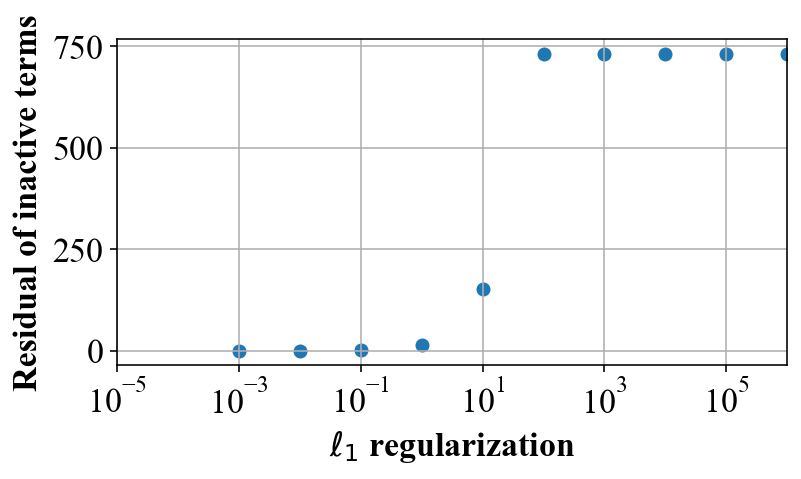

In [31]:
# Sparse PCA to identify directions of nonzero variance
#   First step: model selection for L1 regularization
alphas = [ 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5,1e6]
err = np.zeros([len(alphas)])  # Error defined as norm of inactive terms
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx==i)[0]
        cluster_features = features[feature_idx, :]
        spca = SparsePCA(n_components=1, alpha=alphas[k])#, normalize_components=True)
        spca.fit(cluster_features)
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms ]
    
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])
        
plt.figure(figsize=(6, 3))
plt.scatter(alphas, err)
plt.xlabel(r'$\ell_1$ regularization')
plt.ylabel('Residual of inactive terms')
plt.gca().set_xscale('log')
plt.xlim([1e-5, 1e6])
plt.grid()
plt.show()

In [32]:
# Sparse PCA to identify directions of nonzero variance
alpha_opt =10
spca_model = np.zeros([nc, nfeatures])
for i in range(nc):
    feature_idx = np.nonzero(cluster_idx==i)[0]
    cluster_features = features[feature_idx, :]
    spca = SparsePCA(n_components=1, alpha=alpha_opt)#, normalize_components=True)
    spca.fit(cluster_features)
    print('GMM Cluster {0}:'.format(i))
    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
        spca_model[i, active_terms] = 1  # Set to 1 for active terms in model
    else: print('None')

print(spca_model)

GMM Cluster 0:
None
GMM Cluster 1:
['$\\rho D \\nabla^2 Y_f $', '$\\mu_f ω_g$']
GMM Cluster 2:
['$\\rho u \\frac{\\partial Y_f}{\\partial x}$', '$\\rho D \\nabla^2 Y_f $']
GMM Cluster 3:
['$\\rho D \\nabla^2 Y_f $', '$\\mu_f ω_g$']
GMM Cluster 4:
['$\\rho u \\frac{\\partial Y_f}{\\partial x}$', '$\\rho v \\frac{\\partial Y_f}{\\partial y}$', '$\\rho D \\nabla^2 Y_f $']
GMM Cluster 5:
['$\\rho D \\nabla^2 Y_f $', '$\\mu_f ω_g$']
GMM Cluster 6:
None
GMM Cluster 7:
None
[[0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 0. 1. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### 1.4 Final dominant balance models

In [33]:
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)# To merge clusters with the same principal components
nmodels = balance_models.shape[0]
print(balance_models) # [balance_clurse, feature]
print(model_index)

for i in range(nmodels):
    print('SPCA Cluster {0}:'.format(i))
    active_terms = np.nonzero(balance_models[i, :])[0]
    if len(active_terms)>0:
        print([labels[k] for k in active_terms])
    else: 
        
        print('No dynamics')

# Make new cluster_idx based on SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])  # Divide the original class into classes in the principal component to determine the principal component feature of each region
balancemap = np.reshape(balance_idx, UFx.shape)

[[0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 1. 0.]]
[0 1 2 1 3 1 0 0]
SPCA Cluster 0:
No dynamics
SPCA Cluster 1:
['$\\rho D \\nabla^2 Y_f $', '$\\mu_f ω_g$']
SPCA Cluster 2:
['$\\rho u \\frac{\\partial Y_f}{\\partial x}$', '$\\rho D \\nabla^2 Y_f $']
SPCA Cluster 3:
['$\\rho u \\frac{\\partial Y_f}{\\partial x}$', '$\\rho v \\frac{\\partial Y_f}{\\partial y}$', '$\\rho D \\nabla^2 Y_f $']


gridmap:
 [[0. 0. 0. 0.]
 [0. 0. 2. 2.]
 [3. 0. 3. 0.]
 [4. 4. 4. 0.]]


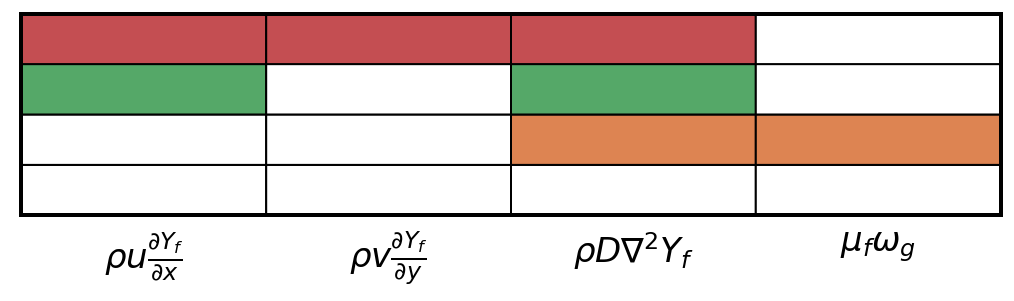

In [34]:
# Plot a grid with active terms in each cluster
gridmap = balance_models.copy()
gridmask = gridmap==0
gridmap = (gridmap.T*np.arange(nmodels)).T+1  # [feature,nc]*range(0,nc)->[feature,nc]-T->[nc,feature] (1~nc): Scale map so that active terms can be color-coded
gridmap[gridmask] = 0 # unactive term remains 0
print("gridmap:\n",gridmap)
grid_labels=labels


%matplotlib inline
plt.figure(figsize=(8, 2))
plt.axes((0.1, 0.24,0.85, 0.7), facecolor='w')
plt.pcolor(gridmap, vmin=-0.5, vmax=cm.N-0.5, cmap=cm, edgecolors='k', linewidth=1)
plt.gca().set_xticks(np.arange(0.5, gridmap.shape[1]+0.5))
plt.gca().set_xticklabels(grid_labels, fontsize=17)
plt.gca().set_yticks(np.arange(0.5, nmodels+0.5))
# plt.gca().set_yticklabels(range(gridmap.shape[0]), fontsize=17)
plt.gca().set_yticklabels([])

for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)

plt.gca().tick_params(axis='both', width=0)
plt.show()
plt.show()

<ipython-input-35-ad1178640ed5>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X*100, Y*100, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')


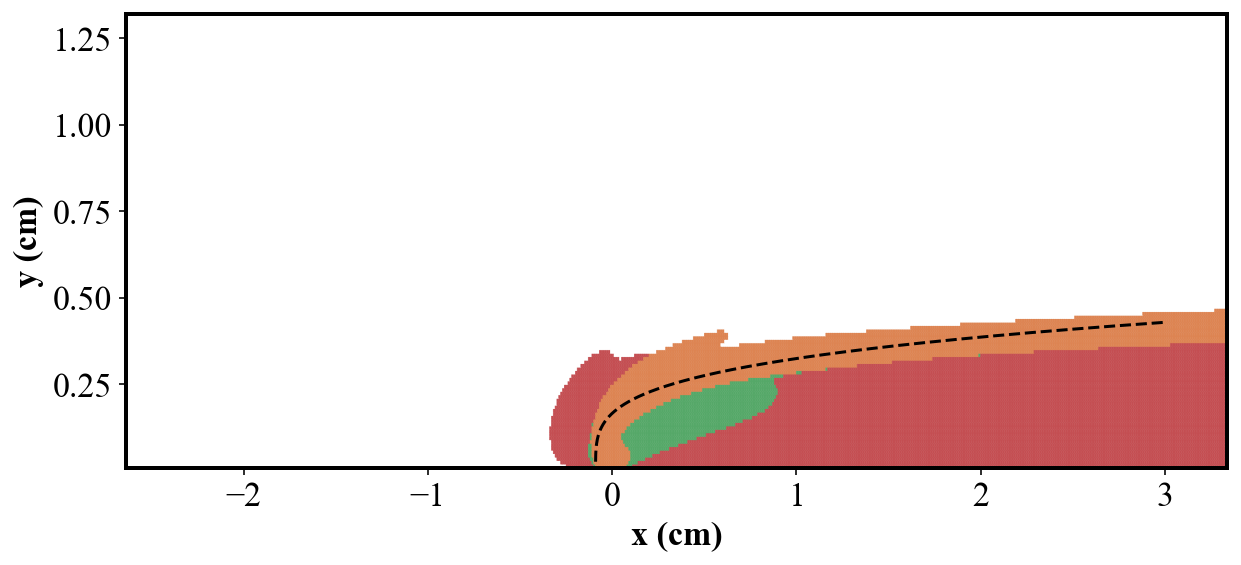

In [35]:
id_noBalance_cluser = np.where(gridmap.sum(axis=1)==0)[0]
balancemap[balancemap==id_noBalance_cluser]=-1

%matplotlib inline
# plt.figure(figsize=(9, 6))
fig = plt.figure(figsize=(9, 4.5))
ax=fig.add_axes([0.1,0.2,0.85,0.7])
ax.pcolor(X*100, Y*100, balancemap+1, cmap=cm, vmin=-0.5, vmax=cm.N-0.5, alpha=1, edgecolors='face')
plt.ylabel('y (cm)')
plt.xlabel('x (cm)')
# plt.title('SPCA Reduction',fontdict={"fontsize":15,"fontweight":"bold","fontname":"Times new roman"})
for axis in ['top','bottom','left','right']:
    plt.gca().spines[axis].set_linewidth(2)
# plot flame stand-off distance curve
xdata = np.linspace(-0.000899,0.03,50000)
ydata = 0.0109*(xdata+0.0009)**(0.2678) # x offset 0.0009 to correct the transition errors
plt.plot(xdata*100,ydata*100,linestyle='--',color='k')

plt.show()